In [1]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import numpy as np
import geopandas as gpd 
from scipy.cluster import hierarchy
import sklearn.metrics as skm
from shapely.geometry import LineString
import math
import networkx as nx
import matplotlib

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
dict_ine_name= {'02': 'Albacete', '03': 'Alicante/Alacant', '04': 'Almería', '01': 'Araba/Álava', '33': 'Asturias', '05': 'Ávila', '06': 'Badajoz', '07': 'Balears Illes',
 '08': 'Barcelona', '48': 'Bizkaia', '09': 'Burgos', '10': 'Cáceres', '11': 'Cádiz', '39': 'Cantabria', '12': 'Castellón/Castelló', '13': 'Ciudad Real', '14': 'Córdoba',
 '15': 'Coruña A', '16': 'Cuenca', '20': 'Gipuzkoa', '17': 'Girona', '18': 'Granada', '19': 'Guadalajara', '21': 'Huelva', '22': 'Huesca', '23': 'Jaén', '24': 'León',
 '25': 'Lleida', '27': 'Lugo', '28': 'Madrid', '29': 'Málaga', '30': 'Murcia', '31': 'Navarra', '32': 'Ourense', '34': 'Palencia', '35': 'Palmas Las', '36': 'Pontevedra',
 '26': 'Rioja La', '37': 'Salamanca', '38': 'Santa Cruz de Tenerife', '40': 'Segovia', '41': 'Sevilla', '42': 'Soria', '43': 'Tarragona', '44': 'Teruel', '45': 'Toledo',
 '46': 'Valencia/València', '47': 'Valladolid', '49': 'Zamora', '50': 'Zaragoza', '51': 'Ceuta', '52': 'Melilla'}

In [78]:
dict_name_ine = {}
for k, v in dict_ine_name.items():
    dict_name_ine[v] = k

In [79]:
df_pop = pd.read_csv('../Map/spain_pop_2017.csv', dtype={'CPRO':str})
df_GDP = pd.read_csv('../Map/spain_GDP_2015.csv', dtype={'CPRO':str})

In [80]:
gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].centroid
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')
gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
gdf_points = gdf_points.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
gdf_points = gdf_points.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
gdf = gdf.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
gdf = gdf.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])


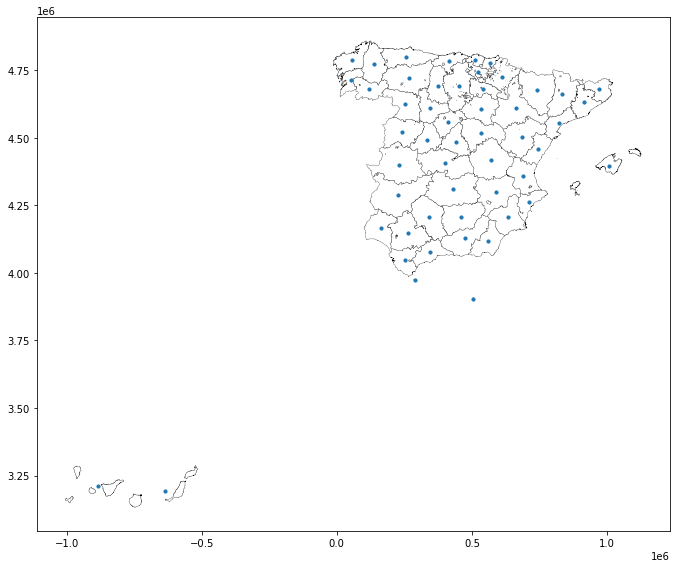

In [43]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
gdf_points.plot(ax=ax, markersize=10)
plt.tight_layout()

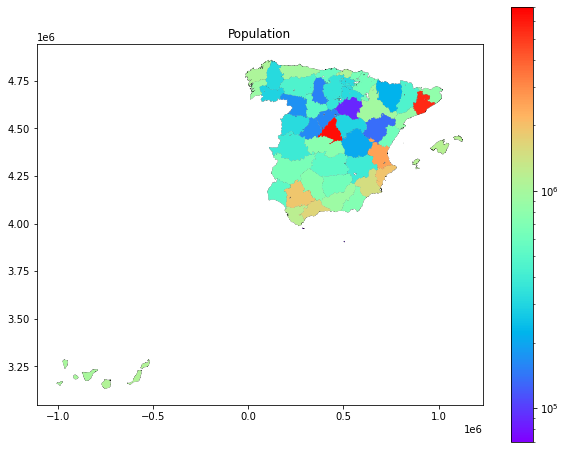

In [44]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
ax.set_title("Population")
gdf.plot(ax=ax, column='POP', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=70_000, vmax=7_000_000))
gdf = gdf.to_crs(4326)

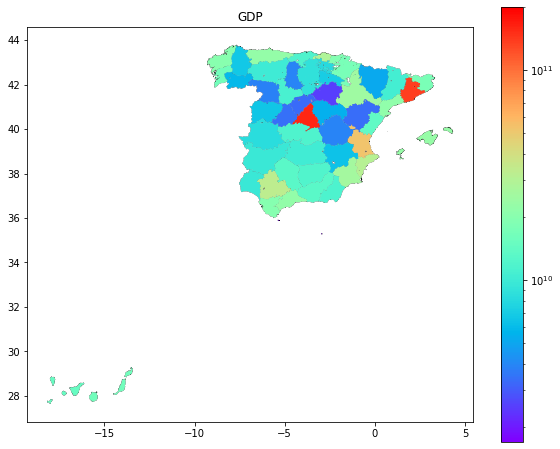

In [45]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
ax.set_title("GDP")
gdf.plot(ax=ax, column='GDP', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1700_000_000, vmax=200_000_000_000))
gdf = gdf.to_crs(4326)

In [81]:
def preprocess(path):
    dtypes = {"Origen":str,"Destino":str,"Año":str,"Mes":str,"Día":str,"Periodo":str,"Modo":str,"Distancia":str,"Residencia":str,"Actividad_Origen":str,"Actividad_Destino":str,
              "Viajeros":str,"Viajeros-km":str}
    df = pd.read_csv(path, encoding="utf-8", dtype=dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Origen2'] = df['Origen'].apply(lambda z: z[:2])
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [82]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.Origen2 == Origen].groupby('Destino2').Viajeros.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['Destino2'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='Destino2', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    destino_distribution['norm_weight'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_weight', ascending=False, inplace=True)
    return destino_distribution

In [83]:
def plot_signiture(df,title,scale = None):
    plt.figure()
    rank = list(range(1, 53))
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df,Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    plt.subplot(1, 1, 1)
    for i in range(1, 53):
        destino_distribution = destino_distributions[str(i).zfill(2)]
        plt.plot(rank, destino_distribution.norm_weight, color='blue', alpha=0.5)
    plt.xlabel('Rank')
    plt.ylabel('Fraction')
    if scale == 'log':
            plt.yscale('log')
            #plt.ylim([-0.1, 1.1])
    plt.title(f'Mobility signiture for {title}')
    plt.tight_layout()

In [84]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df, Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight
    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        origen_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            origen_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    return dist_mat

In [85]:
def plot_distance_matrix(dist_mat):
    plt.figure(figsize=(14, 14))
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], rotation=90)
    plt.yticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)])
    plt.title('distance matrix')

In [86]:
def plot_dendrogram(dist_mat, thr,linkage_method, noplot = False):
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    x = linkage(dist_mat,linkage_method)
    if noplot:
        return dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], no_plot = True, leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
    else: 
        plt.figure(figsize=(12, 6))
        g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        plt.axhline(y=thr, ls=':', color='k')
        plt.ylabel("Distance")
        plt.title(f'{linkage_method}')
        plt.tight_layout()

       # plt.savefig(f"{linkage_method}.pdf")
        return g

In [87]:
def plot_clustered_cities(group, title_name, annotate = False):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   

    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(10,8))
    ax.set_title(title_name)
    for color,coord in group_coord.items() :
        gdf_points[gdf_points.CPRO.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf[gdf.CPRO.isin(coord)].plot(ax=ax, color=color, alpha=0.2)
   
    if annotate :    
        for x, y, label in zip(gdf_points.lon,gdf_points.lat, gdf_points.CPRO):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")


In [88]:
def plot_groups(group,df,scale = None):
    group_avg = []
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]
    unique_colors = np.unique(group['leaves_color_list']).tolist()
    num_cluster = len(unique_colors)
    plt.figure(figsize=(5 * num_cluster, 5))  
    for i ,select_group in enumerate(color_city_group_dict.values()):
        plt.subplot(1, num_cluster, i+1)
        arr_avg = np.array([0.0] * 52)
        for name in select_group:
            ine = dict_name_ine[name]
            distribution = get_destino_distribution(df, ine)
            rank = list(range(1, 53))
            plt.bar(rank,distribution.norm_weight.tolist(), color=unique_colors[i], alpha=1/len(select_group))
            arr_avg += distribution.norm_weight.tolist()
        arr_avg /= len(select_group)

        group_avg.append(arr_avg)
        plt.plot(rank,arr_avg, color='black', ls='--',linewidth=6)
        if scale == 'log':
            plt.yscale('log')
            plt.ylim([0.00001, 1.1])

        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.xlim([-1, 53])
        plt.title('group %d' % (i+1))
        plt.tight_layout()
    return group_avg

In [89]:
def plot_average_clusters(group,group_avg, scale = None):    
    plt.figure(figsize=(5, 5))
    rank = list(range(1, 53))
    unique_colors = np.unique(group['leaves_color_list']).tolist()

    for i in range(len(group_avg)):
        plt.plot(rank, group_avg[i], color=unique_colors[i], ls='-', label='group %d' % (i+1))
        plt.legend()
        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.title('Average of groups')
        plt.xlim([-1, 53])
        if scale == 'log':
            plt.yscale('log')
        plt.tight_layout()


In [90]:
def get_calinski_dict(dist_mat): 
    calinski_dict = {}
    linkage_methods = ['single' ,'complete' ,'average','weighted','centroid','median','ward']
    thresholds = np.linspace(0.6,2.1,7)
    for linkage_method in linkage_methods:
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[linkage_method] = thr_dict

    return calinski_dict

In [91]:
def plot_CalinskiIndex(calinski_dict, noplot = False):
    best_values = {}
    for inkm,data in calinski_dict.items():
        if len(data)>1:
            temp_list = []
            for thr, v in data.items():
                if v['Number of clusters: '] < 8:
                    temp_list.append((thr,v['Calinski-Harabasz Index: ']))
            if noplot == False :
                x, y = zip(*temp_list) 
                plt.plot(x, y,'-s', label = inkm)
                max_y = max(y)
                index = y.index(max_y)
                cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
                plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
                #plt.plot(x[index],max_y,'*')
                plt.legend()
                plt.xlabel('Thresholds')
                plt.ylabel('Calinski-Harabasz Index')
                #plt.title('Thresholds')
                plt.grid(True)
                plt.tight_layout()
                best_values[inkm]= (x[index],max_y)
                
            else:
                x, y = zip(*temp_list) 
                max_y = max(y)
                index = y.index(max_y)
                best_values[inkm]= (x[index],max_y)
    plt.show()
    return best_values

In [92]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

In [93]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

In [94]:
def get_mobility_network(df):
    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    mobility_network = df.groupby(['Origen2', 'Destino2', ]).Viajeros.sum().to_frame('flow')
    mobility_network.reset_index(inplace=True)
    mobility_network['norm_flow'] = mobility_network.apply(lambda z: z.flow / mobility_network[mobility_network.Origen2 == z.Origen2].flow.sum(), axis=1)
    mobility_network['Origen_lon'] = mobility_network.Origen2.map(dict_lon)
    mobility_network['Origen_lat'] = mobility_network.Origen2.map(dict_lat)
    mobility_network['Destino_lon'] = mobility_network.Destino2.map(dict_lon)
    mobility_network['Destino_lat'] = mobility_network.Destino2.map(dict_lat)
    mobility_network['geometry'] = mobility_network.apply(lambda z: LineString([[z.Origen_lon, z.Origen_lat], [z.Destino_lon, z.Destino_lat]]), axis=1)
    mobility_network = gpd.GeoDataFrame(mobility_network, geometry='geometry')
    mobility_network['length'] = mobility_network.geometry.length / 1000
    return mobility_network

In [95]:
def plot_network(mobility_network):
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(1, 1, 1)

    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    g = nx.from_pandas_edgelist(mobility_network, 'Origen2', 'Destino2', ['flow', 'norm_flow'])
    pos = {x: (dict_lon.get(x, 0) , dict_lat.get(x, 0)) for x in set(dict_lat).union(dict_lon)}
    g.add_nodes_from(list(pos.keys()))
    nx.set_node_attributes(g, pos, 'coord')
    node_color = {}
    for idx,name in dict_ine_name.items():
        for k,v in color_city_group_dict.items():
            for i in range(len(v)):
                if v[i] == name:
                    node_color[idx] = k 
    nx.draw_networkx_nodes(g, pos = nx.get_node_attributes(g , 'coord'), ax = ax,node_size=300, node_color=node_color.values(), cmap=plt.cm.tab10)

    edgelist = [(u, v) for (u, v, d) in g.edges(data=True)]
    # edges
   # nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
   #                        width=1, alpha=0.5, edge_color='grey')
    durations = [i['norm_flow']*10 for i in dict(g.edges).values()]
    nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
                       width=durations,  edge_color='k')

    # labels
    nx.draw_networkx_labels(g, pos, ax = ax,font_size=12, font_family='Arial')

    plt.gca()
    ax.margins(0.08)
    plt.axis('off')
    plt.tight_layout()
    return g

In [96]:
thr = 1.6
linkage_method = 'ward'

In [62]:
def get_similarity_matrix(path):
    all_labels = []
    for n in [str(z).zfill(2) for z in range(0, 7)]:
         with open(path + f"{n}" + ".csv", 'r') as f:
            df = preprocess(f)
            dist_mat = get_distance_matrix(df)
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            all_labels.append(labels)
    ARIs = [] 
    for row in all_labels:
        ARI = []
        for row2 in all_labels:
            ARI.append(round(skm.adjusted_rand_score(row,row2),2))
        ARIs.append(ARI)
    return ARIs

In [63]:
data_names = {'00':'Mons_Ave','01':'Tues_Ave','02':'Weds_Ave','03':'Thurs_Ave','04': 'Fris_Ave','05': 'Sats_Ave','06':'Suns_Ave'}
            # '07':'Fri_14','08':'Sat_15','09':'Mon_31', '10':'Mon_First_Aug','11':'Fri_4_Aug','12':'Sat_5_Aug'}

In [64]:
def plot_similarity_matrix(ARIs):
    plt.figure()
    plt.imshow(ARIs, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(7),[data_names[str(i).zfill(2)] for i in range(0, 7)], rotation=90)
    plt.yticks(range(7),[data_names[str(i).zfill(2)] for i in range(0, 7)])
    plt.title('Similaity matrix')

In [97]:
def cal_signiture_entropy(df, CPRO):
    df_signiture = get_destino_distribution(df, str(CPRO))
    return entropy(df_signiture.norm_weight)

In [105]:
def gini_coefficient(x):
#A Gini coefficient of zero expresses perfect equality, where all values are the same (for example, where everyone has the same income).
#A Gini coefficient of one (or 100%) expresses maximal inequality among values (.g., for a large number of people where only one person 
#has all the income or consumption and all others have none, the Gini coefficient will be nearly one).
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [125]:
def get_gdf_points(results):
    gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
    gdf_points = gdf.copy()
    gdf_points['geometry'] = gdf_points['geometry'].centroid
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')
    gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
    gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
    gdf_points = gdf_points.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf_points = gdf_points.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    gdf = gdf.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf = gdf.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    df_gyration = pd.DataFrame(results, columns=['CPRO', 'gyration', 'gyration_unweighted'])
    gdf_points = gdf_points.merge(df_gyration, on=['CPRO'])
    df_color = pd.DataFrame(list(zip(group['ivl'], group['leaves_color_list'])), columns=['NPRO', 'cluster'])
    gdf_points = gdf_points.merge(df_color, on='NPRO')
    gdf_points['signiture_entropy'] = gdf_points.CPRO.apply(lambda z: cal_signiture_entropy(df, z))
    #gdf_points['signiture_gini'] = gdf_points.apply(lambda z: gini_coefficient(z))
    return gdf_points

In [106]:
def plot_signature_gini(df,title):
    plt.figure(figsize=(4, 3))
    
    results = []
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.Origen2 == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_weight),2)
        results.append(g3)
    results = np.array(results)
    plt.hist(results, alpha=0.5, bins=np.linspace(0.6, 1, 21), density=True)
    plt.xlabel('GINI')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.title(title)
    plt.tight_layout()


In [176]:
def plt_ranked_entropy_gyration(group, gdf_points):    
    plt.figure(figsize=(12, 8))
    
    gini = []
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.Origen2 == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_weight),2)
        gini.append(g3)
    gdf_points['signiture_gini'] = gini
    
    
    plt.subplot(2, 3, 1)
    gdf_points.sort_values('signiture_gini', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].signiture_gini, 
                    color=cluster, marker='o')

    plt.xlabel('signiture_gini rank')
    plt.ylabel('signiture_gini')
    plt.tight_layout()


    plt.subplot(2, 3, 2)
    gdf_points.sort_values('gyration', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].gyration, 
                    color=cluster, marker='o')

    plt.xlabel('gyration rank')
    plt.ylabel('gyration')
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    gdf_points.sort_values('signiture_entropy', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.xlabel('signiture_entropy rank')
    plt.ylabel('signiture_entropy')
    plt.tight_layout()
    plt.subplot(2, 3, 4)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].POP, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.ylabel('signiture_entropy')
    plt.xlabel('Population')
    plt.tight_layout()
    
    plt.subplot(2, 3, 5)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].gyration, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.ylabel('signiture_entropy')
    plt.xlabel('gyration')
    plt.tight_layout()
    
    
    gini = []
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.Origen2 == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_weight),2)
        gini.append(g3)
    gdf_points['signiture_gini'] = gini
    plt.subplot(2, 3, 6)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].signiture_gini, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.xlabel('signiture_entropy')
    plt.ylabel('signiture_gini')
    plt.tight_layout()
    
   

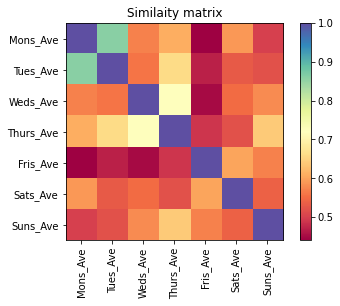

In [167]:
path = "../July/VI_J"
ARIs = get_similarity_matrix(path)
plot_similarity_matrix(ARIs)

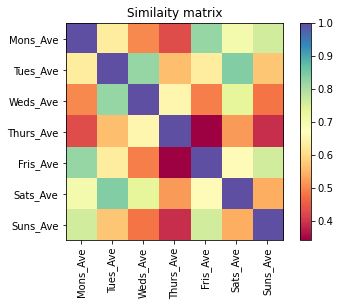

In [168]:
path = "../October/VI_O"
ARIs = get_similarity_matrix(path)
plot_similarity_matrix(ARIs)

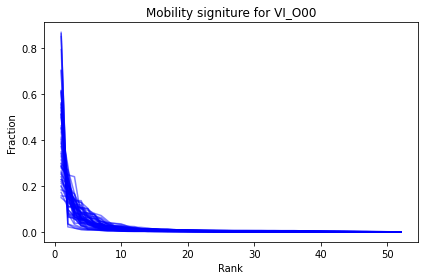

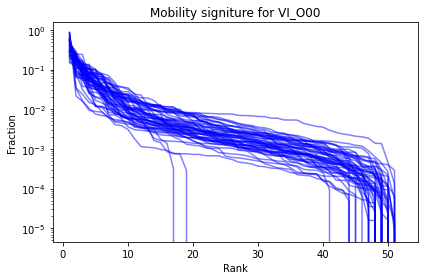

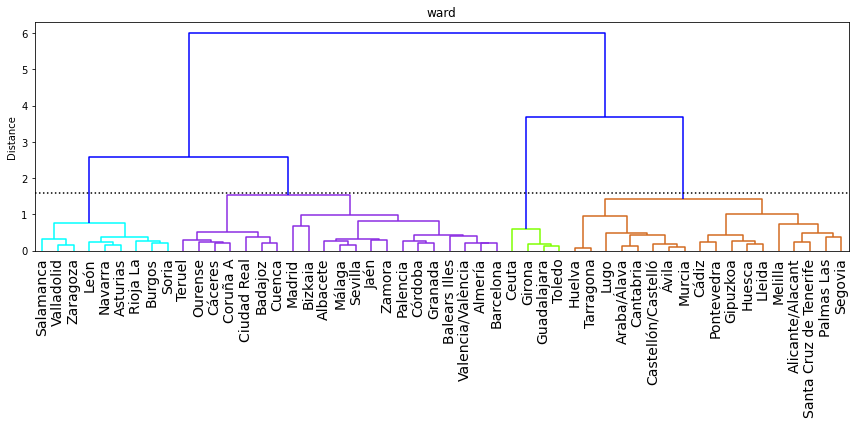

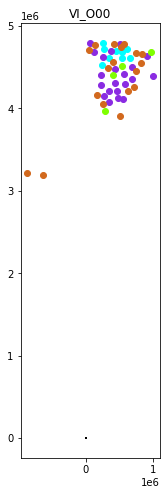

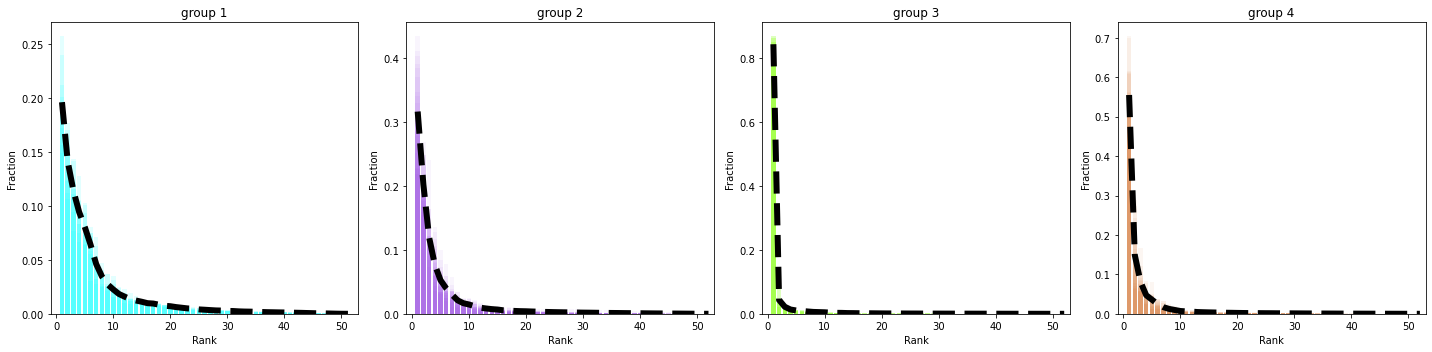

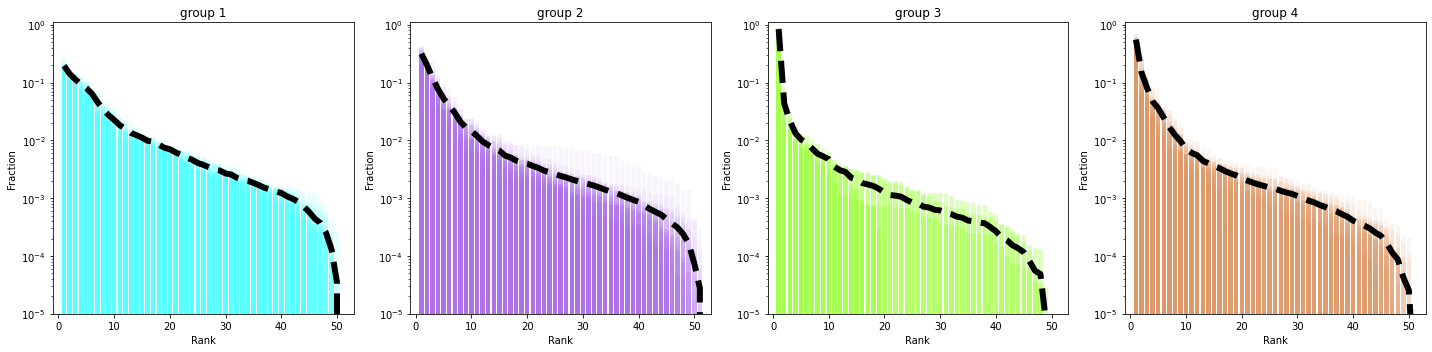

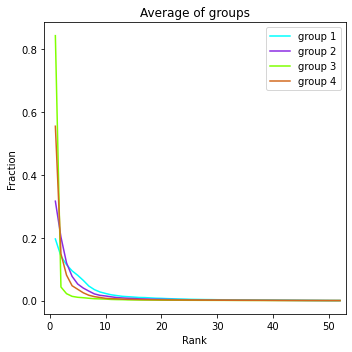

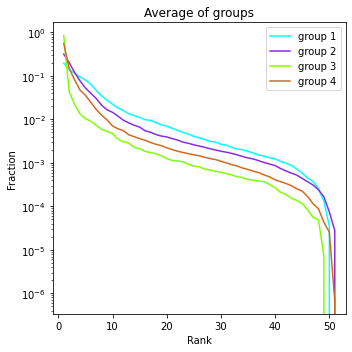

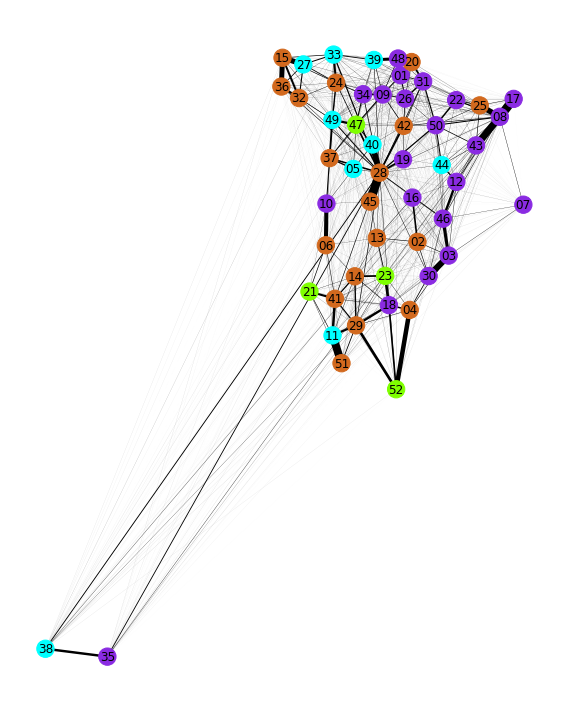

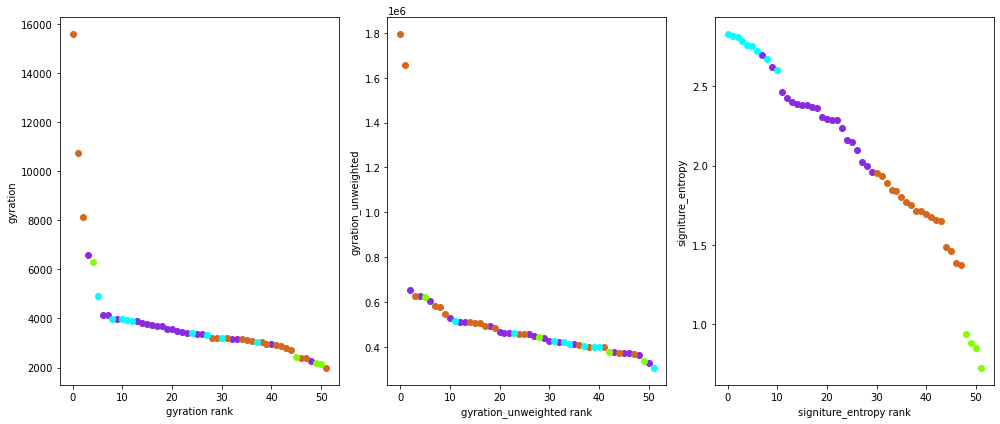

In [71]:
for n in [str(z).zfill(2) for z in range(0, 1)]:#7
     with open(f"../October/VI_O{n}.csv", 'r') as f:
        df = preprocess(f)
        title_name = f"VI_O{n}"
        dist_mat = get_distance_matrix(df)
        plot_signiture(df,title_name)
        plot_signiture(df,title_name, scale = 'log')
        group = plot_dendrogram(dist_mat,thr, linkage_method)
        plot_clustered_cities(group,f"VI_O{n}")
        group_avg = plot_groups(group,df,scale = None)
        group_avg = plot_groups(group,df,scale = 'log')
        plot_average_clusters(group,group_avg, scale = None)
        plot_average_clusters(group,group_avg, scale = 'log')
        mobility_network = get_mobility_network(df)
        plot_network(mobility_network)
        results = []
        for Origen2 in mobility_network.Origen2.unique():
            select = mobility_network[mobility_network.Origen2 == Origen2].copy(True)
            results.append([Origen2, (select.norm_flow * select.length).mean(), select.length.mean()])   
        gdf_points_extended = get_gdf_points(results,gdf_points)
        plt_ranked_entropy_gyration(group, gdf_points_extended)
        

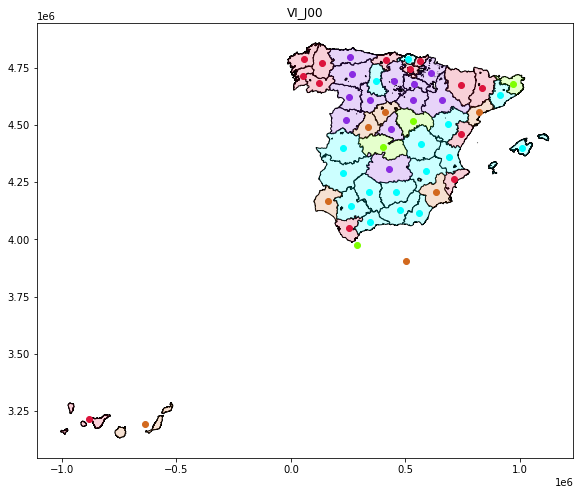

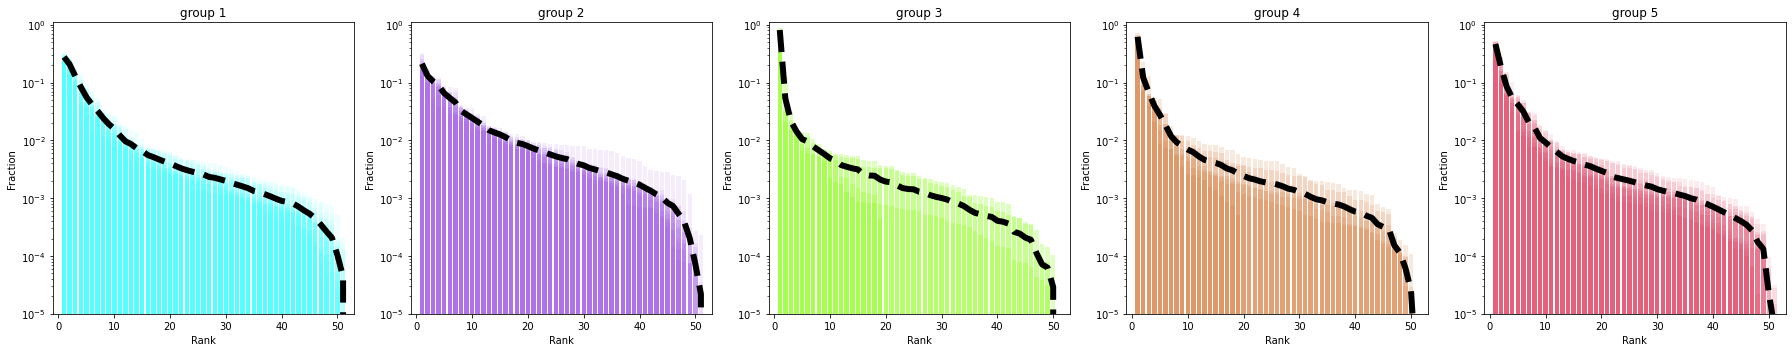

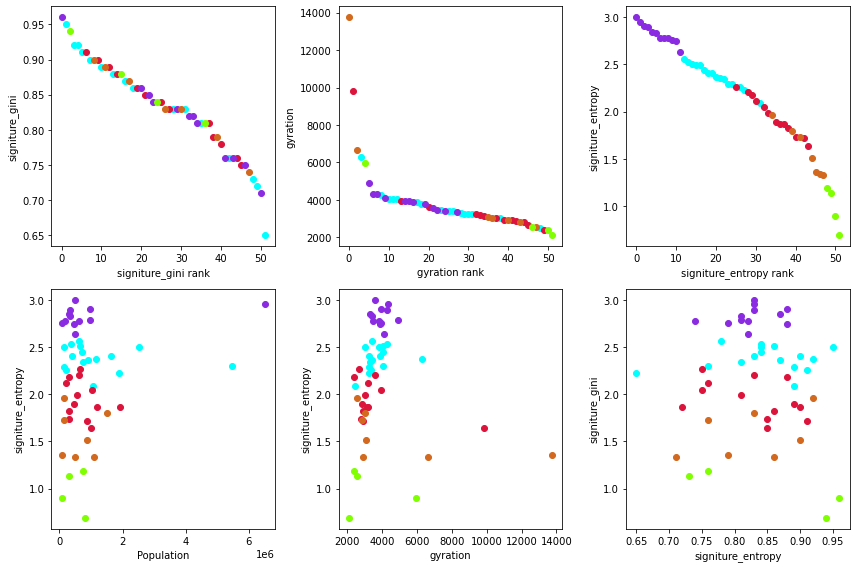

In [177]:
path = "../July/VI_J00.csv"
df = preprocess(path)
title_name = f"VI_J00"
dist_mat = get_distance_matrix(df)
#plot_signiture(df,title_name)
#plot_signiture(df,title_name, scale = 'log')
group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
plot_clustered_cities(group,f"VI_J00")
#group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
#plot_average_clusters(group,group_avg, scale = None)
#plot_average_clusters(group,group_avg, scale = 'log')
mobility_network = get_mobility_network(df)
#plot_network(mobility_network)
results = []
for Origen2 in mobility_network.Origen2.unique():
    select = mobility_network[mobility_network.Origen2 == Origen2].copy(True)
    results.append([Origen2, (select.norm_flow * select.length).mean(), select.length.mean()])   
gdf_points_extended = get_gdf_points(results)
plt_ranked_entropy_gyration(group, gdf_points_extended)
